# PCA: Principal Component Analysis

## Notebook Overview

### Visualizing Autoencoder and Autoencoder-LSTM Performances using PCA
In this notebook we evaluate how different sequence models, namely Dense Autoencoders and LSTM Autoencoders, reconstruct time series data. We use Principal Component Analysis (PCA) to project both the original and reconstructed sequences into two dimensions, which allows us to visually compare the reconstruction quality across models. We do not apply PCA to the LSTM model because reducing feature dimensionality could distort temporal dependencies that the LSTM relies on for accurate forecasting.

### Why PCA?
Reconstruction quality is often measured with numerical metrics such as MSE, but these alone do not show how the reconstructed data is organized in the feature space. PCA provides a visual perspective by reducing the sequences to two dimensions. This allows us to see how well the models preserve the structure of the original data, to identify possible patterns or anomalies, and to compare the reconstructions of different models in a shared space.

### Goals of this notebook
In this notebook we will load or generate the reconstructed outputs from trained models, reshape the sequential data into a PCA-compatible format, and apply PCA to both the original and reconstructed sequences. Finally, we will visualize the results to assess how closely each model reproduces the structure of the input space.

### Imports

In [1]:
import pandas as pd
import numpy as np
import sys
import os
# Getting src path to import modules
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adding src path to the system path, if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.metrics import mean_squared_error, pairwise_distances, explained_variance_score
from dl_models import AutoencoderKfold as ae
from dl_models import AutoencoderLSTMKfold as al
from utils import plots as plts

## Load & Preprocess the Dataset
Before applying PCA, it is essential to prepare the data properly.
The dataframe is loaded, then the features are selected and scaled to a uniform range (e.g., 0 to 1) using MinMaxScaler.
Scaling ensures that all features contribute equally to the PCA, preventing those with larger ranges from dominating the principal components.

In [2]:
# Time series data for a specific building (Building_1.csv/Building_2.csv/Building_3.csv).
electricity_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")

# Carbon intensity data.
carbon_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/carbon_intensity.csv")

# Pricing data.
pricing_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/pricing.csv")

# Weather data.
weather_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/weather.csv")

# Concatenate multiple datasets along the columns to create a single dataset.
df = pd.concat([electricity_data, carbon_data, pricing_data, weather_data], axis=1)

In [3]:
# Target features to forecast
targets = ['cooling_demand', 'carbon_intensity', 'solar_generation']

# List of features used for training the autoencoder.
features = ['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 
            'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 
            'indoor_dry_bulb_temperature_set_point', 'hvac_mode', 'carbon_intensity', 'electricity_pricing', 
            'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h', 'electricity_pricing_predicted_24h', 
            'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 
            'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'outdoor_dry_bulb_temperature_predicted_24h', 
            'outdoor_relative_humidity_predicted_6h', 'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 
            'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h', 
            'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h']

In [4]:
# Select the relevant features from the dataframe
X = df[features]

# Initialize the scaler to scale features to the range [0, 1]
scaler = MinMaxScaler()

# Fit the scaler on X and transform X to scaled values
X_scaled = scaler.fit_transform(X)

## Applying PCA
PCA transforms the original features into a new set of orthogonal components that capture most of the variance in the data. By keeping only the leading components, we reduce the dimensionality of the dataset. This not only simplifies the representation but can also improve generalization, which is especially helpful when training models such as LSTMs and Autoencoders.

In [5]:
# Perform PCA to reduce the number of features to n_components (26 here)
pca = PCA(n_components=26)

# Fit PCA on scaled data and transform it into principal components
X_pca = pca.fit_transform(X_scaled)

print("Data shape after PCA:", X_pca.shape)
print("Explained Variance:\n", pca.explained_variance_ratio_)

# Store the explained variance ratio array and calculate the cumulative explained variance to understand how many components explain most variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Set a threshold for the desired total explained variance
threshold = 0.97  # 97% variance

# Find the minimum number of components required to reach or exceed the threshold
n_components_97 = np.argmax(cumulative_var >= threshold) + 1

print(f"Minimum number of components to explain {threshold*100:.0f}% of the variance: {n_components_97}")

Data shape after PCA: (720, 26)
Explained Variance:
 [0.38889946 0.18302407 0.07570496 0.05762962 0.04306899 0.036288
 0.03105729 0.02322843 0.01979995 0.01636485 0.01542476 0.01378288
 0.01296057 0.01016648 0.00966474 0.00878968 0.00838489 0.00693677
 0.00608119 0.00582085 0.0048821  0.00382521 0.00363734 0.00332571
 0.00311854 0.0019705 ]
Minimum number of components to explain 97% of the variance: 20


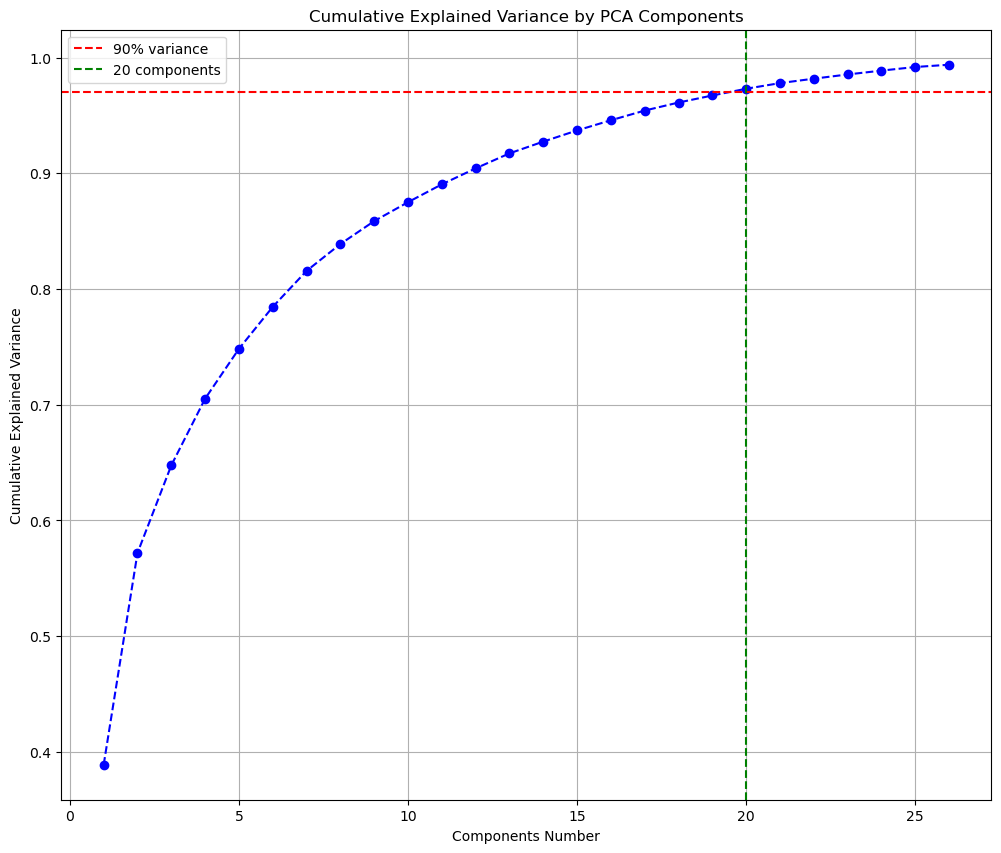

In [6]:
plts.plot_pca_variance(cumulative_var, n_components_97, filename="citylearn_pca.png")

In [7]:
# Create a new PCA instance with the optimal number of components found (to explain 97% variance)
pca_opt = PCA(n_components=n_components_97)
X_pca_opt = pca_opt.fit_transform(X_scaled)

sc_pca = MinMaxScaler(feature_range=(0,1))
X_pca_scaled = sc_pca.fit_transform(X_pca_opt)

print("Data shape after optimal PCA:", X_pca_opt.shape)
print("Explained Variance:\n", pca_opt.explained_variance_ratio_)

# Create a DataFrame for the PCA results with columns named PC0, PC1, ..., PC25
X_pca_scaled_df = pd.DataFrame(X_pca_scaled, columns=[f'PC{i}' for i in range(X_pca_opt.shape[1])])

Data shape after optimal PCA: (720, 20)
Explained Variance:
 [0.38889946 0.18302407 0.07570496 0.05762962 0.04306899 0.036288
 0.03105729 0.02322843 0.01979995 0.01636485 0.01542476 0.01378288
 0.01296057 0.01016648 0.00966474 0.00878968 0.00838489 0.00693677
 0.00608119 0.00582085]


## Autoencoder Training

In [8]:
real_ae, pred_ae, _ = ae.Autoencoder(dataframe=X_pca_scaled_df, features=X_pca_scaled_df.columns.tolist(), epochs = 1000, latent_dim = 64, batch_size = 32)

Epoch 1/1000
16/16 [==============================] - 2s 5ms/step - loss: 0.0345 - mean_absolute_error: 0.1459
Epoch 2/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0307 - mean_absolute_error: 0.1358
Epoch 3/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0284 - mean_absolute_error: 0.1315
Epoch 4/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0255 - mean_absolute_error: 0.1256
Epoch 5/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0224 - mean_absolute_error: 0.1175
Epoch 6/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0195 - mean_absolute_error: 0.1089
Epoch 7/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0173 - mean_absolute_error: 0.1015
Epoch 8/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0154 - mean_absolute_error: 0.0949
Epoch 9/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0136 - mean_absolute_error: 0.0890
E

In [9]:
# Back to the original pca scale
pred_pca_original_ae = sc_pca.inverse_transform(pred_ae)
real_pca_original_ae = sc_pca.inverse_transform(real_ae)

# Back to the original space
pred_original_space_ae = pca_opt.inverse_transform(pred_pca_original_ae)
real_original_space_ae = pca_opt.inverse_transform(real_pca_original_ae)

## Autoencoder-LSTM Training

In [10]:
real_al, pred_al, _ = al.Autoencoder(dataframe=X_pca_scaled_df, features=X_pca_scaled_df.columns.tolist(), epochs = 300, latent_dim = 64, batch_size = 32, timesteps = 6)

Epoch 1/300
16/16 [==============================] - 2s 29ms/step - loss: 0.2046
Epoch 2/300
16/16 [==============================] - 0s 26ms/step - loss: 0.0985
Epoch 3/300
16/16 [==============================] - 0s 27ms/step - loss: 0.0581
Epoch 4/300
16/16 [==============================] - 0s 27ms/step - loss: 0.0412
Epoch 5/300
16/16 [==============================] - 0s 27ms/step - loss: 0.0340
Epoch 6/300
16/16 [==============================] - 0s 27ms/step - loss: 0.0326
Epoch 7/300
16/16 [==============================] - 0s 27ms/step - loss: 0.0323
Epoch 8/300
16/16 [==============================] - 0s 29ms/step - loss: 0.0321
Epoch 9/300
16/16 [==============================] - 0s 27ms/step - loss: 0.0319
Epoch 10/300
16/16 [==============================] - 0s 27ms/step - loss: 0.0319
Epoch 11/300
16/16 [==============================] - 0s 28ms/step - loss: 0.0317
Epoch 12/300
16/16 [==============================] - 0s 26ms/step - loss: 0.0315
Epoch 13/300
16/16 [=====

In [14]:
orig_shape = pred_al.shape

pred_flat = pred_al.reshape(-1, orig_shape[-1])
real_flat = real_al.reshape(-1, orig_shape[-1])

pred_pca_original_al = sc_pca.inverse_transform(pred_flat)
real_pca_original_al = sc_pca.inverse_transform(real_flat)

pred_pca_original_al = pred_pca_original_al.reshape(orig_shape)
real_pca_original_al = real_pca_original_al.reshape(orig_shape)

pred_original_space_al = pca_opt.inverse_transform(pred_pca_original_al.reshape(-1, orig_shape[-1]))
real_original_space_al = pca_opt.inverse_transform(real_pca_original_al.reshape(-1, orig_shape[-1]))

pred_original_space_al = pred_original_space_al.reshape(orig_shape[0], orig_shape[1], -1)
real_original_space_al = real_original_space_al.reshape(orig_shape[0], orig_shape[1], -1)

## Results
Visualizing the results after the PCA procedures on the trained models through graphs with normalized errors.

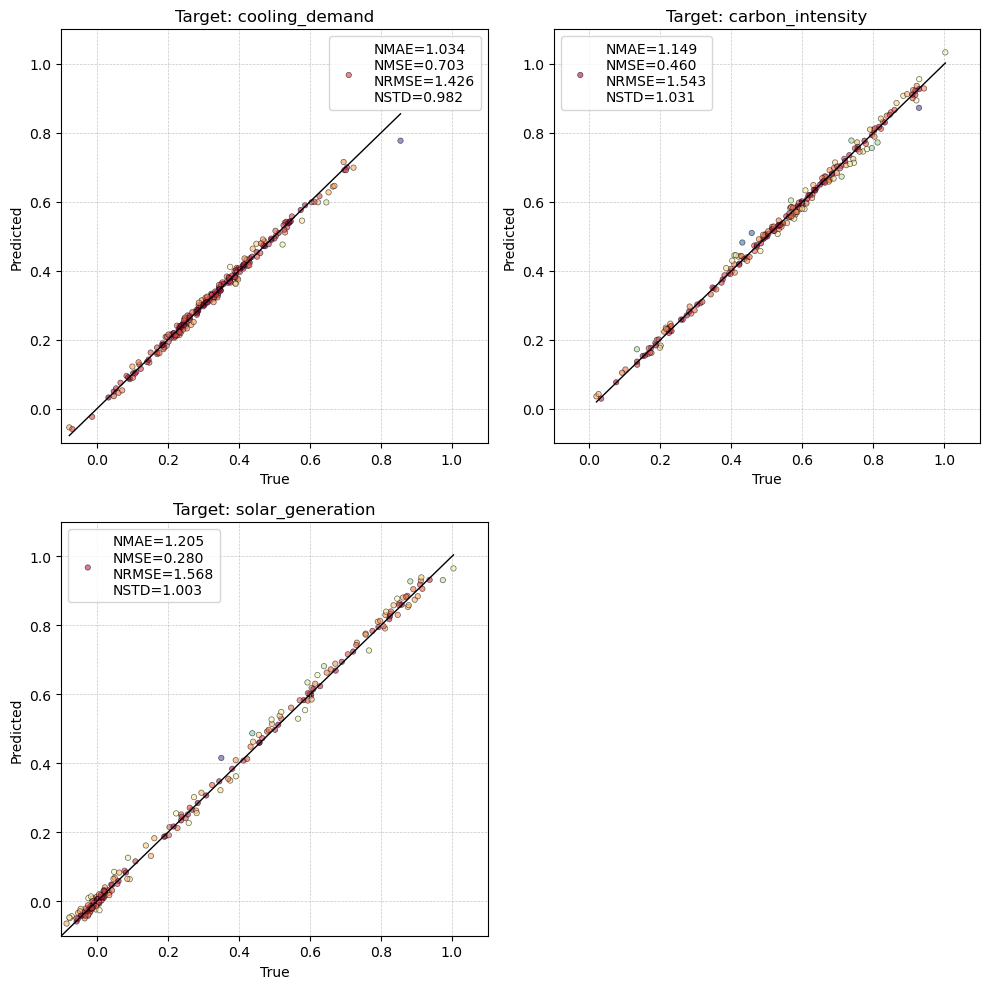

In [15]:
# Autoencoder
plts.plot_targets(real_original_space_ae, pred_original_space_ae, targets, features, percent=True, filename="autoencoder_pca.png")

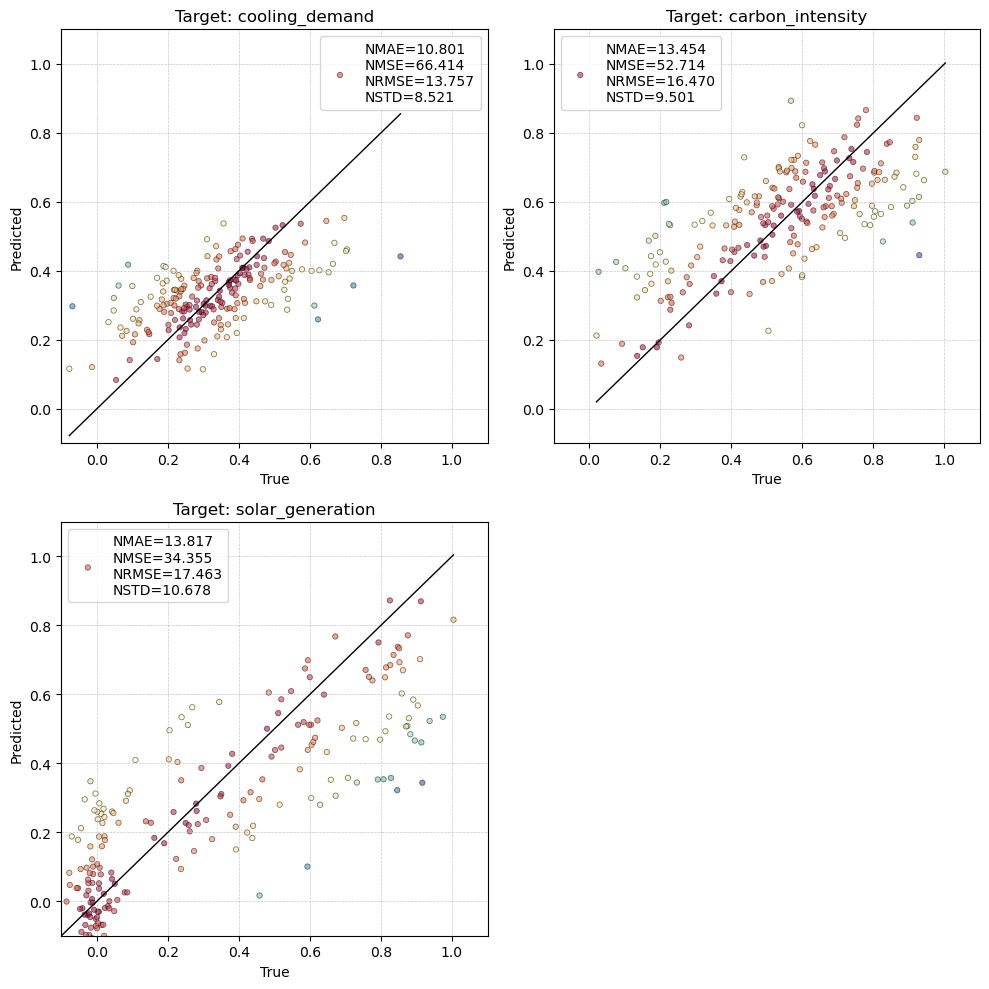

In [16]:
# Autoencoder-LSTM
plts.plot_aelstm_targets(real_original_space_al, pred_original_space_al, targets, features, percent=True,  filename="autoencoderLSTM_pca.png")